# **Mount Drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Loading & Preprocessing

In [2]:
import json
import math
import os

import cv2
from PIL import Image
import numpy as np
from keras import layers
from keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import Adam
from keras.applications.densenet import DenseNet201
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools
from sklearn.metrics import classification_report


%matplotlib inline

In [3]:
#Transfer 'jpg' images to an array IMG
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".png":
            img = read(PATH)
           
            img = cv2.resize(img, (RESIZE,RESIZE))
           
            IMG.append(np.array(img))
    return IMG

benign_train = np.array(Dataset_loader('/content/drive/MyDrive/BreastCancerProject/DataSet/CBISDatasetforBenignandMalignent/train/Benign',224))
malign_train = np.array(Dataset_loader('/content/drive/MyDrive/BreastCancerProject/DataSet/CBISDatasetforBenignandMalignent/train/Malignant',224))
benign_test = np.array(Dataset_loader('/content/drive/MyDrive/BreastCancerProject/DataSet/CBISDatasetforBenignandMalignent/test/Benign',224))
malign_test = np.array(Dataset_loader('/content/drive/MyDrive/BreastCancerProject/DataSet/CBISDatasetforBenignandMalignent/test/Malignant',224))

100%|██████████| 116/116 [00:02<00:00, 54.92it/s]


# Create Label

In [5]:
# Create labels

benign_train_label = np.zeros(len(benign_train))
malign_train_label = np.ones(len(malign_train))
benign_test_label = np.zeros(len(benign_test))
malign_test_label = np.ones(len(malign_test))

# Merge data 
X_train = np.concatenate((benign_train, malign_train), axis = 0)
Y_train = np.concatenate((benign_train_label, malign_train_label), axis = 0)
X_test = np.concatenate((benign_test, malign_test), axis = 0)
Y_test = np.concatenate((benign_test_label, malign_test_label), axis = 0)

# Shuffle train data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

# Shuffle test data
s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

# To categorical
Y_train = to_categorical(Y_train, num_classes= 2)
Y_test = to_categorical(Y_test, num_classes= 2)

# Train and Evalutation split

In [6]:
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train, 
    test_size=0.2, 
    random_state=11
)

# Display Some Images

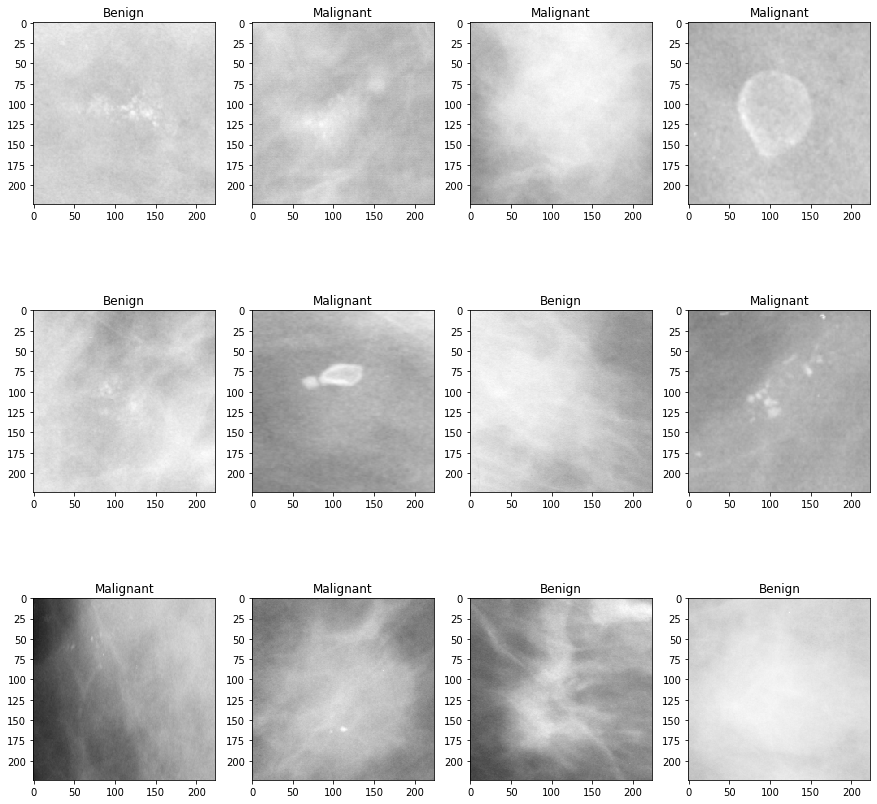

In [7]:

# # Display first 15 images of moles, and how they are classified
w=60
h=40
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(Y_train[i]) == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(x_train[i], interpolation='nearest')
plt.show()

# Data Generator

In [9]:
BATCH_SIZE = 32

# Using original generator
train_generator = ImageDataGenerator(
        zoom_range=2,  # set range for random zoom
        rotation_range = 90,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
    )

In [10]:
def build_model(backbone, lr=1e-4):
    model = Sequential()
    model.add(backbone)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(2, activation='softmax'))
    
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=lr),
        metrics=['accuracy']
    )
    
    return model

In [11]:
K.clear_session()
gc.collect()

incep = InceptionV3(include_top=False,input_shape=[224,224,3])


model = build_model(incep ,lr = 1e-4)
model.summary()

87924736/87910968 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 batch_normalization_94 (Bat  (None, 2048)             8192      
 chNormalization)                                                
                                                                 
 dense (Dense)               (None, 2)                 4098      
                                                         

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [12]:
# Learning Rate Reducer
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,verbose=1,factor=0.2, min_lr=1e-4)

# Checkpoint
filepath="/content/drive/MyDrive/BreastCancerProject/Models/weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Training & Evaluation

In [13]:
history = model.fit_generator(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=50,
    validation_data=(x_val, y_val),
    callbacks=[learn_control, checkpoint]
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/50
74/73 [==============================] - ETA: 0s - loss: 0.8511 - accuracy: 0.5533
Epoch 1: val_accuracy improved from -inf to 0.54685, saving model to /content/drive/MyDrive/BreastCancerProject/Models/weights.best.hdf5
73/73 [==============================] - 62s 539ms/step - loss: 0.8511 - accuracy: 0.5533 - val_loss: 0.7116 - val_accuracy: 0.5468 - lr: 1.0000e-04
Epoch 2/50
74/73 [==============================] - ETA: 0s - loss: 0.7692 - accuracy: 0.5951
Epoch 2: val_accuracy did not improve from 0.54685
73/73 [==============================] - 34s 465ms/step - loss: 0.7692 - accuracy: 0.5951 - val_loss: 0.7400 - val_accuracy: 0.5264 - lr: 1.0000e-04
Epoch 3/50
74/73 [==============================] - ETA: 0s - loss: 0.7635 - accuracy: 0.5844
Epoch 3: val_accuracy improved from 0.54685 to 0.59625, saving model to /content/drive/MyDrive/BreastCancerProject/Models/weights.best.hdf5
73/73 [==============================] - 39s 537ms/step - loss: 0.7635 - accuracy: 0.5844 - 

In [14]:
  with open('history.json', 'w') as f:
    json.dump(str(history.history), f)

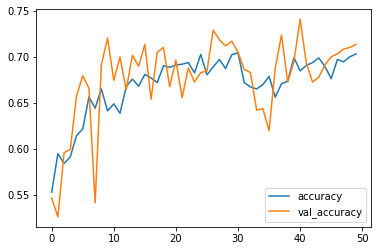

In [15]:
with open('history.json', 'w') as f:
  json.dump(str(history.history), f)

history_df = pd.DataFrame(history.history)
history_df[['accuracy', 'val_accuracy']].plot()

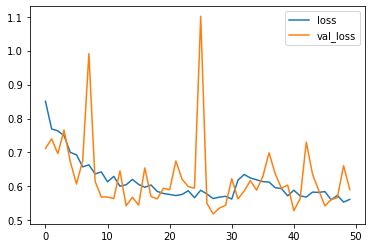

In [16]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()

In [ ]:
model.save(filepath)

# Prediction

In [17]:
model.load_weights(filepath)

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 batch_normalization_94 (Bat  (None, 2048)             8192      
 chNormalization)                                                
                                                                 
 dense (Dense)               (None, 2)                 4098      
                                                                 
Total params: 21,815,074
Trainable params: 21,776,546
No

In [19]:
Y_val_pred = model.predict(x_val)


In [20]:
accuracy_score(np.argmax(y_val, axis=1), np.argmax(Y_val_pred, axis=1))

0.7410562180579217

In [21]:
Y_pred = model.predict(X_test)


In [22]:
tta_steps = 10
predictions = []

for i in tqdm(range(tta_steps)):
    preds = model.predict_generator(train_generator.flow(X_test, batch_size=BATCH_SIZE, shuffle=False),
                                    steps = len(X_test)/BATCH_SIZE)
    
    predictions.append(preds)
    gc.collect()
    
Y_pred_tta = np.mean(predictions, axis=0)

  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  
100%|██████████| 10/10 [00:44<00:00,  4.43s/it]


### Confusion Matrix

Confusion matrix, without normalization
[[136  42]
 [ 53  63]]


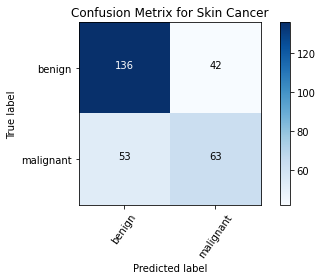

In [25]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))

cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Metrix for Skin Cancer')

Confusion matrix, without normalization
[[124  54]
 [ 45  71]]


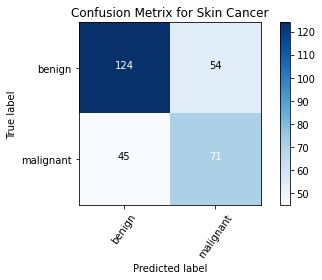

In [26]:
cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))

cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Metrix for Skin Cancer')

### Classification Report

In [27]:
from sklearn.metrics import classification_report
classification_report( np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))

'              precision    recall  f1-score   support\n\n           0       0.73      0.70      0.71       178\n           1       0.57      0.61      0.59       116\n\n    accuracy                           0.66       294\n   macro avg       0.65      0.65      0.65       294\nweighted avg       0.67      0.66      0.67       294\n'

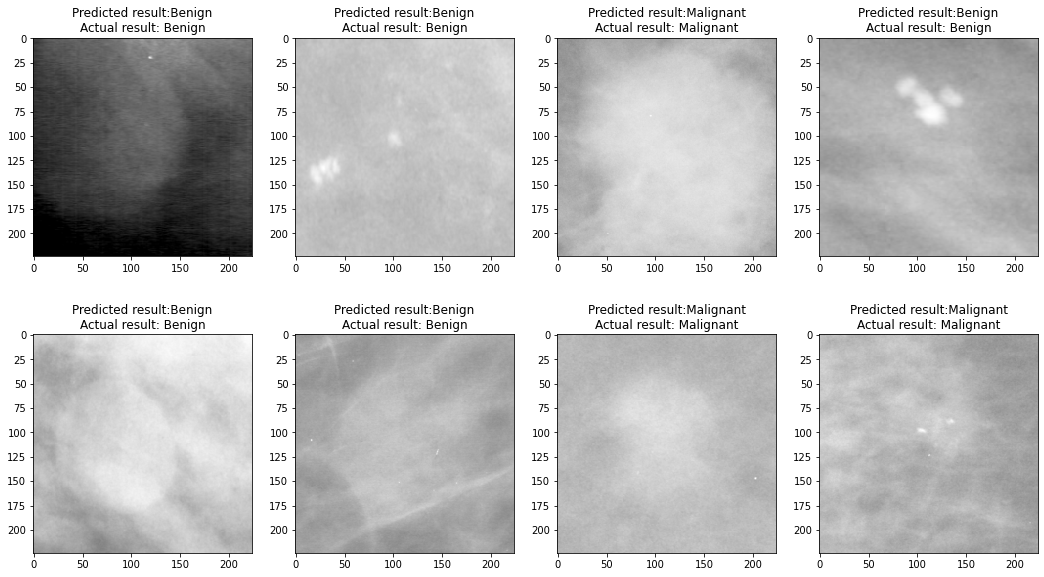

In [ ]:


def Transfername(namecode):
    if namecode==0:
        return "Benign"
    else:
        return "Malignant"
    
for i in range(len(prop_class)):
    ax = fig.add_subplot(rows, columns, i+1)
    ax.set_title("Predicted result:"+ Transfername(np.argmax(Y_pred_tta[prop_class[i]]))
                       +"\n"+"Actual result: "+ Transfername(np.argmax(Y_test[prop_class[i]])))
    plt.imshow(X_test[prop_class[i]], interpolation='nearest')
plt.show()

# **INBreast Training**

# **Loading DataSet**

In [28]:
#Transfer 'jpg' images to an array IMG
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".png":
            img = read(PATH)
           
            img = cv2.resize(img, (RESIZE,RESIZE))
           
            IMG.append(np.array(img))
    return IMG

benign_train = np.array(Dataset_loader('/content/drive/MyDrive/BreastCancerProject/DataSet/INBreastDatasetforBenignandMalignent/train/Benign',224))
malign_train = np.array(Dataset_loader('/content/drive/MyDrive/BreastCancerProject/DataSet/INBreastDatasetforBenignandMalignent/train/Malignant',224))
benign_test = np.array(Dataset_loader('/content/drive/MyDrive/BreastCancerProject/DataSet/INBreastDatasetforBenignandMalignent/test/Benign',224))
malign_test = np.array(Dataset_loader('/content/drive/MyDrive/BreastCancerProject/DataSet/INBreastDatasetforBenignandMalignent/test/Malignant',224))

100%|██████████| 10/10 [00:05<00:00,  1.95it/s]


# **Create Labels**

In [29]:

# Create labels
benign_train_label = np.zeros(len(benign_train))
malign_train_label = np.ones(len(malign_train))
benign_test_label = np.zeros(len(benign_test))
malign_test_label = np.ones(len(malign_test))

# Merge data 
X_train = np.concatenate((benign_train, malign_train), axis = 0)
Y_train = np.concatenate((benign_train_label, malign_train_label), axis = 0)
X_test = np.concatenate((benign_test, malign_test), axis = 0)
Y_test = np.concatenate((benign_test_label, malign_test_label), axis = 0)

# Shuffle train data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

# Shuffle test data
s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

# To categorical
Y_train = to_categorical(Y_train, num_classes= 2)
Y_test = to_categorical(Y_test, num_classes= 2)

# **Split Dataset**

In [30]:
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train, 
    test_size=0.15, 
    random_state=11
)

# **Display Some Images**

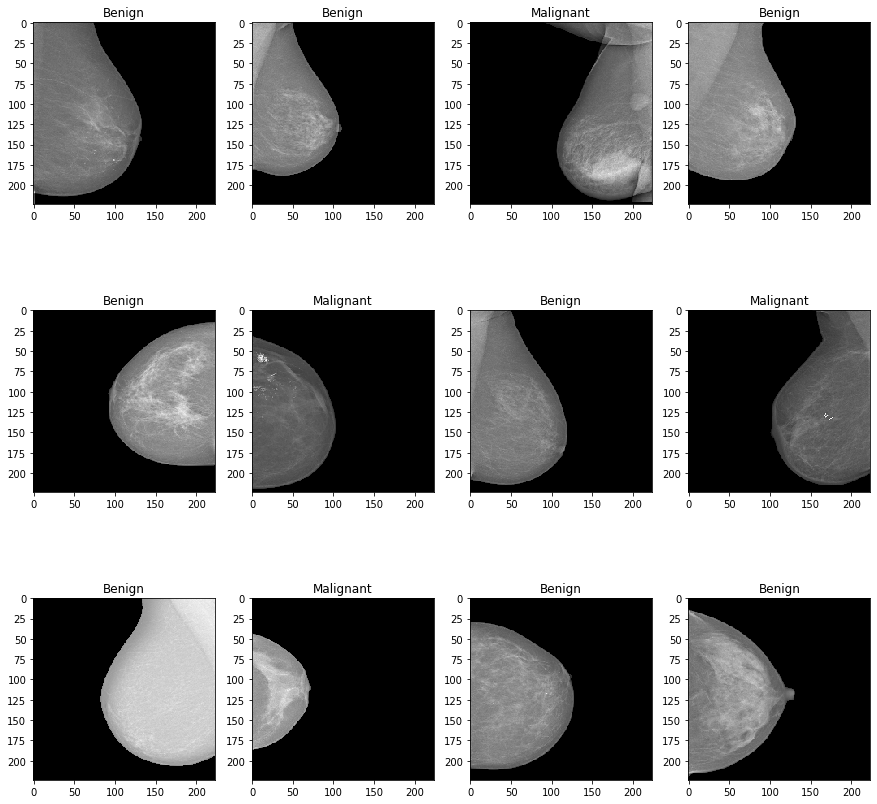

In [31]:

# # Display first 15 images of moles, and how they are classified
w=60
h=40
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(Y_train[i]) == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(x_train[i], interpolation='nearest')
plt.show()

# **DataSet Generator**

In [32]:
BATCH_SIZE = 16

# Using original generator
train_generator = ImageDataGenerator(
        zoom_range=2,  # set range for random zoom
        rotation_range = 90,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
    )

# **Load Previous Model**

In [33]:
from tensorflow import keras

filepath="/content/drive/MyDrive/BreastCancerProject/Models/weights.best.hdf5" 
model = keras.models.load_model(filepath) 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 batch_normalization_94 (Bat  (None, 2048)             8192      
 chNormalization)                                                
                                                                 
 dense (Dense)               (None, 2)                 4098      
                                                                 
Total params: 21,815,074
Trainable params: 21,776,546
No

# **Start Training**

In [34]:
filepath="/content/drive/MyDrive/BreastCancerProject/Models/weights.best.hdf5"
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,verbose=1,factor=0.2, min_lr=1e-4)
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
history = model.fit_generator(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=30,
    validation_data=(x_val, y_val),
    callbacks=[learn_control, checkpoint]
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if __name__ == '__main__':


Epoch 1/30
17/16 [===============================] - ETA: 0s - loss: 0.7772 - accuracy: 0.5267
Epoch 1: val_accuracy improved from -inf to 0.82979, saving model to /content/drive/MyDrive/BreastCancerProject/Models/weights.best.hdf5
16/16 [==============================] - 16s 573ms/step - loss: 0.7772 - accuracy: 0.5267 - val_loss: 0.5663 - val_accuracy: 0.8298 - lr: 1.0000e-04
Epoch 2/30
17/16 [===============================] - ETA: 0s - loss: 0.6825 - accuracy: 0.6260
Epoch 2: val_accuracy did not improve from 0.82979
16/16 [==============================] - 4s 244ms/step - loss: 0.6825 - accuracy: 0.6260 - val_loss: 0.5535 - val_accuracy: 0.8085 - lr: 1.0000e-04
Epoch 3/30
17/16 [===============================] - ETA: 0s - loss: 0.6746 - accuracy: 0.6565
Epoch 3: val_accuracy did not improve from 0.82979
16/16 [==============================] - 4s 242ms/step - loss: 0.6746 - accuracy: 0.6565 - val_loss: 0.5800 - val_accuracy: 0.7872 - lr: 1.0000e-04
Epoch 4/30
17/16 [=============

# **Save Results in Json File**

In [35]:
with open('history.json', 'w') as f:
    json.dump(str(history.history), f)

# **Save Model**

In [36]:
filepath = '/content/drive/MyDrive/BreastCancerProject/Models/weights_INBreast.hdf5'
model.save(filepath)

# **Plot Results**

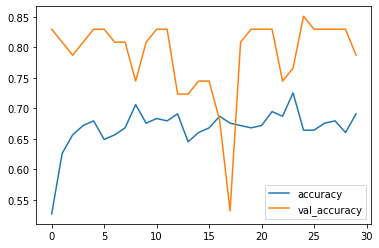

In [37]:
history_df = pd.DataFrame(history.history)
history_df[['accuracy', 'val_accuracy']].plot()

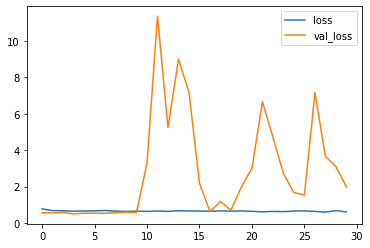

In [38]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()

# **Load Saved Model**

In [46]:
filepath = '/content/drive/MyDrive/BreastCancerProject/Models/weights.best.hdf5'
model.load_weights(filepath)

# **Prediction**

In [47]:
Y_val_pred = model.predict(x_val) 
accuracy_score(np.argmax(y_val, axis=1), np.argmax(Y_val_pred, axis=1))

0.851063829787234

In [41]:
Y_pred = model.predict(X_test)
tta_steps = 10
predictions = []

for i in tqdm(range(tta_steps)):
    preds = model.predict_generator(train_generator.flow(X_test, batch_size=BATCH_SIZE, shuffle=False),
                                    steps = len(X_test)/BATCH_SIZE)
    
    predictions.append(preds)
    gc.collect()
    
Y_pred_tta = np.mean(predictions, axis=0)

  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  import sys
100%|██████████| 10/10 [00:10<00:00,  1.04s/it]


# **Confusion Matrix**

Confusion matrix, without normalization
[[22  2]
 [ 7  3]]


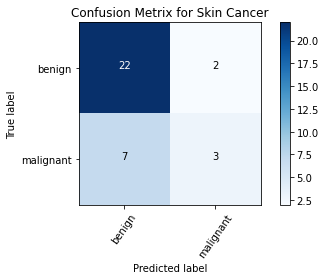

In [42]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))

cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Metrix for Skin Cancer') 



Confusion matrix, without normalization
[[24  0]
 [10  0]]


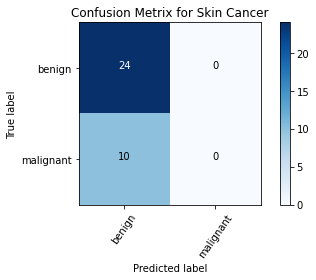

In [43]:

cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))

cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Metrix for Skin Cancer')

# **Classification Report**

In [44]:
from sklearn.metrics import classification_report
classification_report( np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


'              precision    recall  f1-score   support\n\n           0       0.71      1.00      0.83        24\n           1       0.00      0.00      0.00        10\n\n    accuracy                           0.71        34\n   macro avg       0.35      0.50      0.41        34\nweighted avg       0.50      0.71      0.58        34\n'

# **Prediction Results**

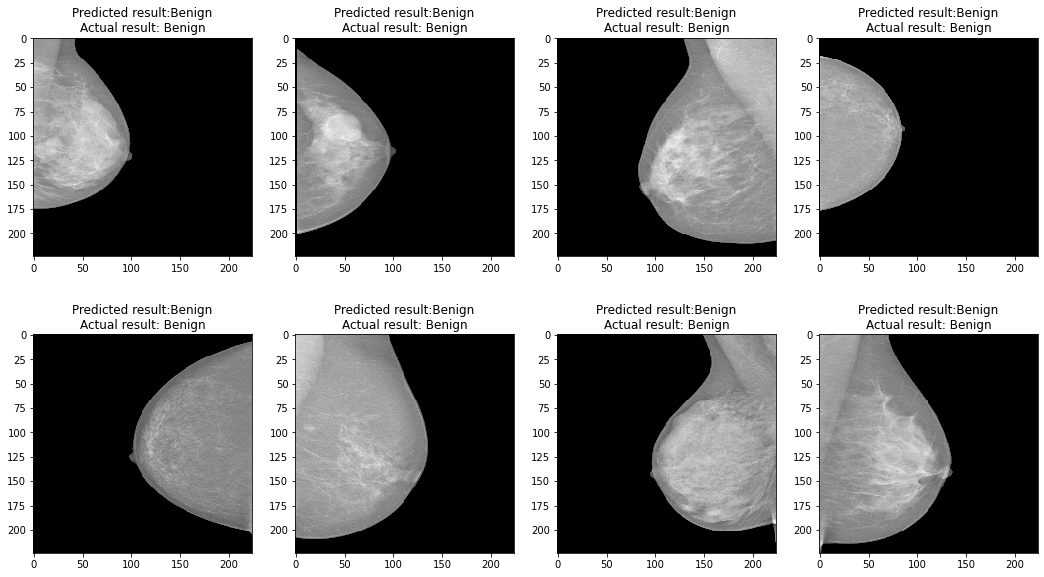

In [ ]:
i=0
prop_class=[]
mis_class=[]

for i in range(len(Y_test)):
    if(np.argmax(Y_test[i])==np.argmax(Y_pred_tta[i])):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(Y_test)):
    if(not np.argmax(Y_test[i])==np.argmax(Y_pred_tta[i])):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

# # Display first 8 images of benign
w=60
h=40
fig=plt.figure(figsize=(18, 10))
columns = 4
rows = 2

def Transfername(namecode):
    if namecode==0:
        return "Benign"
    else:
        return "Malignant"
    
for i in range(len(prop_class)):
    ax = fig.add_subplot(rows, columns, i+1)
    ax.set_title("Predicted result:"+ Transfername(np.argmax(Y_pred_tta[prop_class[i]]))
                       +"\n"+"Actual result: "+ Transfername(np.argmax(Y_test[prop_class[i]])))
    plt.imshow(X_test[prop_class[i]], interpolation='nearest')
plt.show()

In [ ]:
%cd '/content/drive/MyDrive/BreastCancerProject'

!pwd

/content/drive/MyDrive/BreastCancerProject
/content/drive/MyDrive/BreastCancerProject


In [ ]:
!gdown 'https://drive.google.com/drive/folders/1-3NcG6_IResA6i8_YI2E9LXla6dZqzhU?usp=sharing'

/usr/local/lib/python3.7/dist-packages/gdown/parse_url.py:39: UserWarning: You specified a Google Drive link that is not the correct link to download a file. You might want to try `--fuzzy` option or the following url: https://drive.google.com/uc?id=None
  url="https://drive.google.com/uc?id={}".format(file_id)
Downloading...
From: https://drive.google.com/drive/folders/1-3NcG6_IResA6i8_YI2E9LXla6dZqzhU?usp=sharing
To: /content/drive/MyDrive/BreastCancerProject/1-3NcG6_IResA6i8_YI2E9LXla6dZqzhU?usp=sharing
866kB [00:00, 45.2MB/s]
